In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

rcParams['font.family'] = ['Trebuchet MS']
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
abgrid_long = pd.read_excel("./analysis/abgrid_long.xlsx")
abgrid_wide = pd.read_excel("./analysis/abgrid_wide.xlsx")
safa_anx =  pd.read_excel("./analysis/safa_anx.xlsx")
mmpia = pd.read_excel("./analysis/mmpia.xlsx")
mmpia = mmpia.sort_values(by="id").set_index("id")

abgrid_long.head()

,id,anno,contesto,lettera,ic_a,pr_a,bt_a,cl_a,hu_a,nd_a,ic_b,pr_b,bt_b,cl_b,hu_b,nd_b,received_preferences,received_rejections,given_preferences,given_rejections,mutual_preferences,mutual_rejections,balance,orientation,impact,affiliation_coeff_raw,influence_coeff_raw,affiliation_coeff,influence_coeff,status
0,abbamondi mario,i,stu,A,0.000000,0.004934,0.000000,0.000000,0.017801,1,0.054054,0.017352,0.008258,0.054054,0.057605,0,0,2,3,3,0,0,-2,0,2,-2,0,92.250230,92.453141,underrated
1,albanese michelle,i,stu,B,0.027027,0.042179,0.141479,0.335949,0.019750,0,0.027027,0.029406,0.005255,0.204247,0.081605,0,1,1,3,3,0,1,0,0,2,0,1,95.977967,94.946886,underrated
2,bagatin giulio,i,stu,C,0.054054,0.011243,0.014802,0.202878,0.025469,0,0.000000,0.011076,0.000000,0.000000,0.018157,1,2,0,3,3,0,0,2,0,2,2,2,99.705705,97.440630,underrated
3,bonfanti francesca,i,stu,D,0.378378,0.051730,0.091629,0.395484,0.042549,0,0.027027,0.015355,0.000751,0.040541,0.001682,0,14,1,3,2,1,0,13,1,15,14,15,122.072130,129.859311,popular
4,ciliento giacomo pio,i,stu,E,0.081081,0.038719,0.022472,0.343332,0.039374,0,0.000000,0.011076,0.000000,0.000000,0.000000,3,3,0,3,0,0,0,3,3,3,6,3,107.161180,99.934375,-


## ABGRID

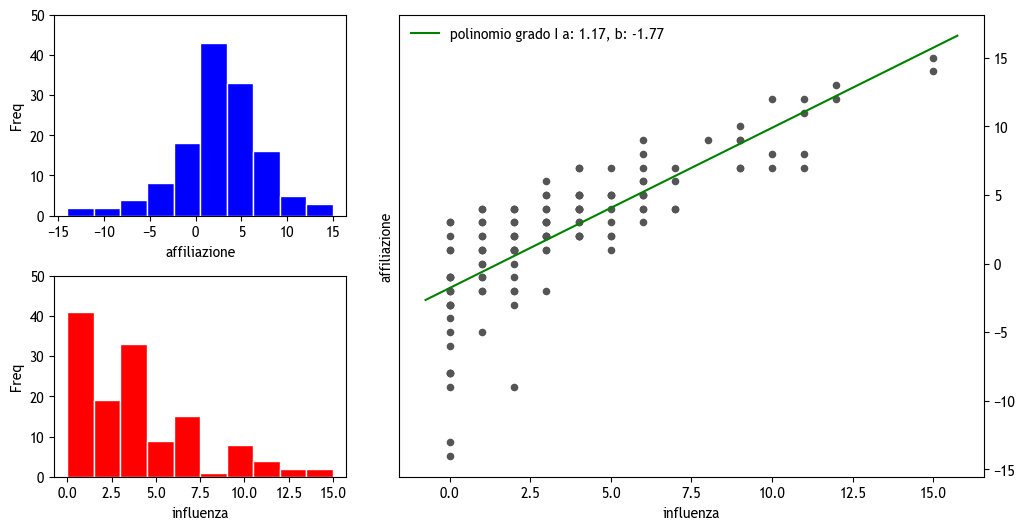

In [3]:
fig = plt.figure(figsize=(12,6))

AFF = "affiliation_coeff_raw"
INF = "influence_coeff_raw"

gs = GridSpec(nrows=2, ncols=2, width_ratios=[1,2], hspace=.3, wspace=.12)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

abgrid_long[AFF].plot.hist(ax=ax1, color="#00F", ec='#FFF')
ax1.set_xlabel("affiliazione")

abgrid_long[INF].plot.hist(ax=ax2, color="#F00", ec='#FFF')
ax2.set_xlabel("influenza")

for ax in (ax1, ax2):
    ax.set_ylabel("Freq")
    ax.set_ylim(0,50)


abgrid_long.plot.scatter(x=INF, y=AFF, color="#555555",  ax=ax3)

coefficients = np.polyfit(abgrid_long[INF], abgrid_long[AFF], 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(ax3.get_xlim()[0], ax3.get_xlim()[1], abgrid_long[INF].shape[0])
y_line = polynomial(x_line)

ax3.plot(x_line, y_line, color='green', label=f'polinomio grado I a: {coefficients[0].round(2) }, b: {coefficients[1].round(2)}')

ax3.yaxis.tick_right()
ax3.set_xlabel("influenza")
ax3.set_ylabel("affiliazione")
ax3.legend(frameon=False);
fig.savefig("./analysis/aff_inf.png", bbox_inches='tight')

In [4]:
abgrid_wide_multi_index = abgrid_long.pivot(index="id", columns=["anno", "contesto"])
idx = pd.IndexSlice

abgrid_wide_i = abgrid_wide.set_index("id")
abgrid_wide_i.head()

,lettera_lud_i,lettera_stu_i,lettera_lud_ii,lettera_stu_ii,ic_a_lud_i,ic_a_stu_i,ic_a_lud_ii,ic_a_stu_ii,pr_a_lud_i,pr_a_stu_i,pr_a_lud_ii,pr_a_stu_ii,bt_a_lud_i,bt_a_stu_i,bt_a_lud_ii,bt_a_stu_ii,cl_a_lud_i,cl_a_stu_i,cl_a_lud_ii,cl_a_stu_ii,hu_a_lud_i,hu_a_stu_i,hu_a_lud_ii,hu_a_stu_ii,nd_a_lud_i,nd_a_stu_i,nd_a_lud_ii,nd_a_stu_ii,ic_b_lud_i,ic_b_stu_i,ic_b_lud_ii,ic_b_stu_ii,pr_b_lud_i,pr_b_stu_i,pr_b_lud_ii,pr_b_stu_ii,bt_b_lud_i,bt_b_stu_i,bt_b_lud_ii,bt_b_stu_ii,cl_b_lud_i,cl_b_stu_i,cl_b_lud_ii,cl_b_stu_ii,hu_b_lud_i,hu_b_stu_i,hu_b_lud_ii,hu_b_stu_ii,nd_b_lud_i,nd_b_stu_i,nd_b_lud_ii,nd_b_stu_ii,received_preferences_lud_i,received_preferences_stu_i,received_preferences_lud_ii,received_preferences_stu_ii,received_rejections_lud_i,received_rejections_stu_i,received_rejections_lud_ii,received_rejections_stu_ii,given_preferences_lud_i,given_preferences_stu_i,given_preferences_lud_ii,given_preferences_stu_ii,given_rejections_lud_i,given_rejections_stu_i,given_rejections_lud_ii,given_rejections_stu_ii,mutual_preferences_lud_i,mutual_preferences_stu_i,mutual_preferences_lud_ii,mutual_preferences_stu_ii,mutual_rejections_lud_i,mutual_rejections_stu_i,mutual_rejections_lud_ii,mutual_rejections_stu_ii,balance_lud_i,balance_stu_i,balance_lud_ii,balance_stu_ii,orientation_lud_i,orientation_stu_i,orientation_lud_ii,orientation_stu_ii,impact_lud_i,impact_stu_i,impact_lud_ii,impact_stu_ii,affiliation_coeff_raw_lud_i,affiliation_coeff_raw_stu_i,affiliation_coeff_raw_lud_ii,affiliation_coeff_raw_stu_ii,influence_coeff_raw_lud_i,influence_coeff_raw_stu_i,influence_coeff_raw_lud_ii,influence_coeff_raw_stu_ii,affiliation_coeff_lud_i,affiliation_coeff_stu_i,affiliation_coeff_lud_ii,affiliation_coeff_stu_ii,influence_coeff_lud_i,influence_coeff_stu_i,influence_coeff_lud_ii,influence_coeff_stu_ii,status_lud_i,status_stu_i,status_lud_ii,status_stu_ii
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
abbamondi mario,A,A,A,A,0.081081,0.000000,0.107143,0.107143,0.042997,0.004934,0.057399,0.061845,0.011887,0.000000,0.052910,0.072156,0.303332,0.000000,0.366700,0.394366,0.053911,0.017801,0.050918,0.040528,0,1,0.0,0.0,0.054054,0.054054,0.035714,0.107143,0.018422,0.017352,0.025082,0.106543,0.014264,0.008258,0.000000,0.005291,0.054054,0.054054,0.047619,0.251742,0.048975,0.057605,0.000000,0.043932,0,0,2.0,0.0,3,0,3.0,3.0,2,2,1.0,3.0,3,3,3.0,3.0,3,3,0.0,1.0,2,0,2.0,1.0,0,0,0.0,1.0,1,-2,2.0,0.0,0,0,3.0,2.0,5,2,4.0,6.0,1,-2,5.0,2.0,5,0,5.0,4.0,97.971054,92.250230,105.222232,97.899230,104.019421,92.453141,102.650214,100.882583,controversial,underrated,-,controversial
albanese michelle,B,B,B,B,0.027027,0.027027,0.178571,0.035714,0.009828,0.042179,0.038896,0.013434,0.021396,0.141479,0.150551,0.039638,0.061776,0.335949,0.388593,0.247788,0.015650,0.019750,0.009917,0.026952,0,0,0.0,0.0,0.000000,0.027027,0.035714,0.000000,0.008635,0.029406,0.042476,0.009501,0.000000,0.005255,0.033069,0.000000,0.000000,0.204247,0.194444,0.000000,0.032719,0.081605,0.081769,0.065713,1,0,0.0,1.0,1,1,5.0,1.0,0,1,1.0,0.0,3,3,3.0,3.0,3,3,3.0,3.0,1,0,2.0,1.0,0,1,1.0,0.0,1,0,4.0,1.0,0,0,0.0,0.0,1,2,6.0,1.0,1,0,4.0,1.0,2,1,7.0,2.0,97.971054,95.977967,102.655372,95.868487,93.605466,94.946886,109.333362,95.194825,neglected,underrated,-,neglected
bagatin giulio,C,C,NaN,NaN,0.081081,0.054054,NaN,NaN,0.027810,0.011243,NaN,NaN,0.050075,0.014802,NaN,NaN,0.284029,0.202878,NaN,NaN,0.080617,0.025469,NaN,NaN,0,0,NaN,NaN,0.000000,0.000000,NaN,NaN,0.008635,0.011076,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,0.047432,0.018157,NaN,NaN,1,1,NaN,NaN,3,2,NaN,NaN,0,0,NaN,NaN,3,3,NaN,NaN,3,3,NaN,NaN,0,0,NaN,NaN,0,0,NaN,NaN,3,2,NaN,NaN,0,0,NaN,NaN,3,2,NaN,NaN,3,2,NaN,NaN,3,2,NaN,NaN,101.826052,99.705705,NaN,NaN,97.076785,97.440630,NaN,NaN,-,underrated,NaN,NaN
bonfanti francesca,D,D,C,C,0.027027,0.378378,0.107143,0.250000,0.013109,0.051730,0.012132,0.024796,0.017267,0.091629,0.036243,0.109832,0.027027,0.395484,0.185969,0.261682,0.0059

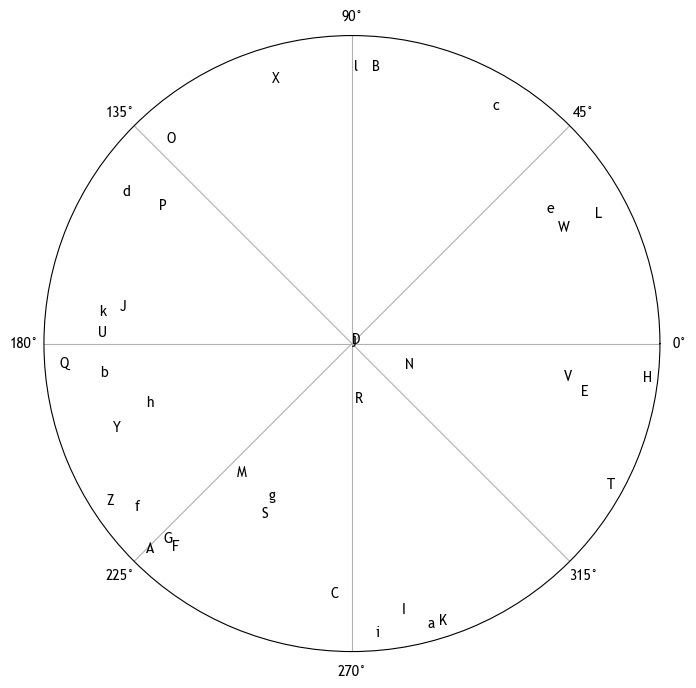

In [33]:
# Compute areas and colors
labels = abgrid_wide_i.loc[:, "lettera_stu_i"]

influence = abgrid_wide_i.loc[:, "influence_coeff_raw_stu_i"]
influence = influence.rsub(influence.max())

affiliation = abgrid_wide_i.loc[:, "affiliation_coeff_raw_stu_i"]



# Add controlled randomness to theta
base_theta = 2 * np.pi * affiliation

# Add small random jitter (adjust the multiplier to control amount of jitter)
jitter = np.random.uniform(-2 * np.pi, 2 * np.pi, size=len(affiliation))  # ±0.1 radians ≈ ±5.7 degrees

theta = base_theta + jitter
r = influence

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, alpha=0) 

for i, txt in enumerate(labels.values):
    ax.annotate(txt, (theta.iloc[i], r.iloc[i]))

ax.get_yaxis().set_ticks([])

    
fig.savefig("./analysis/polar.png", bbox_inches='tight')

